# Evaluation of final models predicting EMPO_3

Load final models from model_joblibs folder and compares models by performance metrics.
* Accuracy Score
* Confusion Matrix
* Classification Report

model_comparison.py performs the same functions, and is useful to generate performance metrics for any given y_true and y_pred. 


In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from helpers import (get_training_observations, 
                     get_training_labels,
                     get_test_observations,
                     get_test_labels,
                     get_protein_proportions)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import load
# sklearn package functions
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Load models and generate predictions

In [6]:
# load test data
x_test = get_test_observations()
y_test = get_test_labels()['EMPO_3']

Getting all test observations from 'metagenome_classification.db'...
Getting all test labels from 'metagenome_classification.db'...


In [7]:
# load XGB label encoder
xgb_le=load('../model_joblibs/xgb_labelEncoder.joblib')
# get list of labels
labels = np.array(xgb_le.classes_)
print(labels)

['Aerosol (non-saline)' 'Animal corpus' 'Animal proximal gut'
 'Hypersaline (saline)' 'Plant corpus' 'Plant rhizosphere' 'Plant surface'
 'Sediment (non-saline)' 'Sediment (saline)' 'Soil (non-saline)'
 'Subsurface (non-saline)' 'Surface (non-saline)' 'Surface (saline)'
 'Water (non-saline)' 'Water (saline)']


In [4]:
# put all models into a nested dictionary
models = {}

In [5]:
# load XGB model
models['XGB'] = {}
models['XGB']['model'] = load('../model_joblibs/xgb_model.joblib')
# predict with testing data set
xgb_pred = models['XGB']['model'].predict(x_test).astype('int64')
# convert encoded predictions into labels
models['XGB']['pred'] = xgb_le.inverse_transform(xgb_pred)

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [9]:
# load decision tree model
models['Decision Tree'] = {}
models['Decision Tree']['model'] = load('../model_joblibs/decision_tree.joblib')
models['Decision Tree']['pred'] = models['Decision Tree']['model'].predict(x_test)

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [16]:
# load neural network model
# models['NN'] = {}
# models['NN']['model'] = load('../model_joblibs/neural_network_EMPO3.joblib')
# models['NN']['pred'] = models['NN']['model'].predict(x_test).astype('int64')

2022-08-02 13:49:06.144291: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


17/17 [==============================] - 0s 11ms/step


In [46]:
# predictions should be an array of strings
models['Decision Tree']['pred'][:5]

array(['Water (non-saline)', 'Water (non-saline)', 'Plant rhizosphere',
       'Subsurface (non-saline)', 'Water (non-saline)'], dtype=object)

## Accuracy

In [10]:
for model in models.keys():
    print(f"{model} Accuracy Score", accuracy_score(y_test, models[model]['pred']))

XGB Accuracy Score 0.9794776119402985
Decision Tree Accuracy Score 0.9626865671641791


## Confusion Matrix

XGB Confusion Matrix


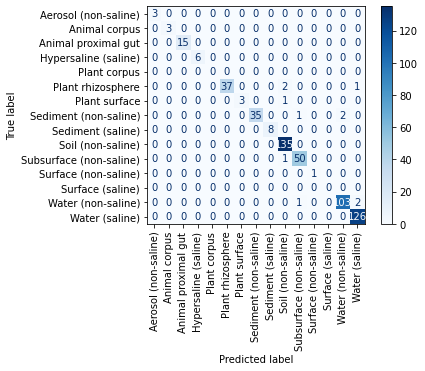

Decision Tree Confusion Matrix


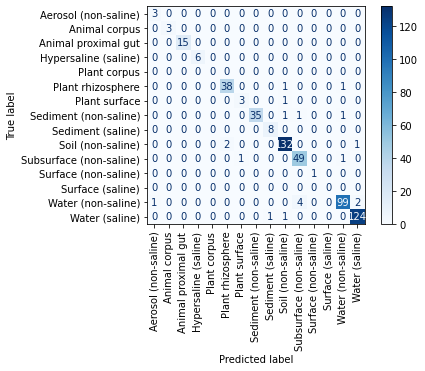

In [45]:
def cm(y_pred):
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=90)
    plt.show()
    
# display confusion matrix for each model
for model in models.keys():
    print (f"{model} Confusion Matrix")
    cm(models[model]['pred'])

# Classification Report

In a nutshell, the major difference between ROC AUC and F1 is related to class imbalance. Here is a summary of reading many StackOverflow threads on how to choose one over the other:

**If you have a high class imbalance, always choose the F1 score because a high F1 score considers both precision and recall.** To get a high F1, both false positives and false negatives must be low. On the other hand, ROC AUC can give precious high scores with a high enough number of false positives. Besides, you can also think of the ROC AUC score as the average of F1 scores (both good and bad) evaluated at various thresholds. Always use F1 when you have a class imbalance. Higher ROC AUC does not necessarily mean a better classifier.

[Source: Comprehensive Guide to Multiclass Classification Metrics](https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd)

In [30]:
def print_clf_rpt(y_true, y_pred):
    print(classification_report(y_true, y_pred, zero_division=0))
    # zero_divison hides UndefinedMetricWarning: zero scores are due to labels not appearing in y_pred
    # In these instances, refer to the 'weighted avg'
    
for model in models.keys():
    print(f"{model} Classification Report")
    print_clf_rpt(y_test, models[model]['pred'])

XGB Classification Report
                         precision    recall  f1-score   support

   Aerosol (non-saline)       1.00      1.00      1.00         3
          Animal corpus       1.00      1.00      1.00         3
    Animal proximal gut       1.00      1.00      1.00        15
   Hypersaline (saline)       1.00      1.00      1.00         6
      Plant rhizosphere       1.00      0.93      0.96        40
          Plant surface       1.00      0.75      0.86         4
  Sediment (non-saline)       1.00      0.92      0.96        38
      Sediment (saline)       1.00      1.00      1.00         8
      Soil (non-saline)       0.97      1.00      0.99       135
Subsurface (non-saline)       0.96      0.98      0.97        51
   Surface (non-saline)       1.00      1.00      1.00         1
     Water (non-saline)       0.98      0.97      0.98       106
         Water (saline)       0.98      1.00      0.99       126

               accuracy                           0.98       5

In [31]:
def plot_classification_report(y_true, y_pred):
    # Generates classification report with color gradation for scores
    df = pd.DataFrame(classification_report(y_true, 
                                   y_pred, 
                                   zero_division=0, 
                                   output_dict=True)).T
    # zero_divison hides UndefinedMetricWarning: zero scores are due to labels not appearing in y_pred
    # In these instances, refer to the 'weighted avg'
    df['support'] = df.support.apply(int)
    df = df.style.background_gradient(cmap='Blues',
                             subset=(df.index[:-3],
            df.columns[:df.columns.get_loc('f1-score')+1])).format(precision=4)
    display(df)

    
    
for model in models.keys():
    print(f"{model} Classification Report")
    plot_classification_report(y_test, models[model]['pred'])

XGB Classification Report


,precision,recall,f1-score,support
Aerosol (non-saline),1.0000,1.0000,1.0000,3
Animal corpus,1.0000,1.0000,1.0000,3
Animal proximal gut,1.0000,1.0000,1.0000,15
Hypersaline (saline),1.0000,1.0000,1.0000,6
Plant rhizosphere,1.0000,0.9250,0.9610,40
Plant surface,1.0000,0.7500,0.8571,4
Sediment (non-saline),1.0000,0.9211,0.9589,38
Sediment (saline),1.0000,1.0000,1.0000,8
Soil (non-saline),0.9712,1.0000,0.9854,135
Subsurface (non-saline),0.9615,0.9804,0.9709,51


Decision Tree Classification Report


,precision,recall,f1-score,support
Aerosol (non-saline),0.7500,1.0000,0.8571,3
Animal corpus,1.0000,1.0000,1.0000,3
Animal proximal gut,1.0000,1.0000,1.0000,15
Hypersaline (saline),1.0000,1.0000,1.0000,6
Plant rhizosphere,0.9500,0.9500,0.9500,40
Plant surface,0.7500,0.7500,0.7500,4
Sediment (non-saline),1.0000,0.9211,0.9589,38
Sediment (saline),0.8889,1.0000,0.9412,8
Soil (non-saline),0.9706,0.9778,0.9742,135
Subsurface (non-saline),0.9074,0.9608,0.9333,51


# Put funcions into a wrapper for individual evaluation

Test Set Accuracy 0.9794776119402985
Confusion Matrix


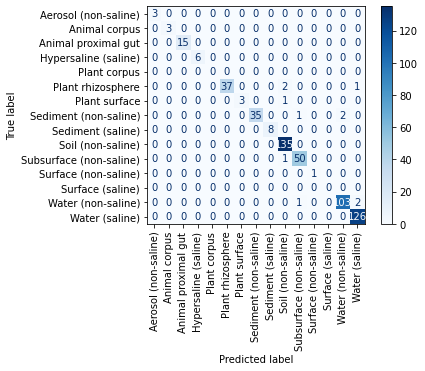

Classification Report


,precision,recall,f1-score,support
Aerosol (non-saline),1.000000,1.000000,1.000000,3
Animal corpus,1.000000,1.000000,1.000000,3
Animal proximal gut,1.000000,1.000000,1.000000,15
Hypersaline (saline),1.000000,1.000000,1.000000,6
Plant rhizosphere,1.000000,0.925000,0.961039,40
Plant surface,1.000000,0.750000,0.857143,4
Sediment (non-saline),1.000000,0.921053,0.958904,38
Sediment (saline),1.000000,1.000000,1.000000,8
Soil (non-saline),0.971223,1.000000,0.985401,135
Subsurface (non-saline),0.961538,0.980392,0.970874,51


In [40]:
# example of how eval wrapper is used in model_comparison.py
def eval_wrapper(y_pred):
    print(f"Accuracy Score", accuracy_score(y_test, y_pred))
    print (f"Confusion Matrix")
    cm(y_pred)
    print(f"Classification Report")
    plot_classification_report(y_pred)

eval_wrapper(models['XGB']['pred'])